Checking CSV path: /kaggle/input/plant-pathology-2020-fgvc7/train.csv
Checking test CSV path: /kaggle/input/plant-pathology-2020-fgvc7/test.csv
Checking images directory: /kaggle/input/plant-pathology-2020-fgvc7/images
Loading and extracting features for training set...

Class distribution in training set:
healthy: 516 positive samples (28.34%)
multiple_diseases: 91 positive samples (5.00%)
rust: 622 positive samples (34.16%)
scab: 592 positive samples (32.51%)
Loaded 1821 valid samples
Total features: 1666, HOG features: 1568
Training models...
Training samples: 1456, Validation samples: 365
Validation paths: 365, Validation labels: 365

Prediction distribution for SVM:
healthy: 90.0 positive predictions (24.66%)
multiple_diseases: 0.0 positive predictions (0.00%)
rust: 118.0 positive predictions (32.33%)
scab: 157.0 positive predictions (43.01%)

multiple_diseases specifics for SVM:
  True multiple_diseases samples: 18 (4.93%)
  Predicted multiple_diseases samples: 0.0 (0.00%)

Predi

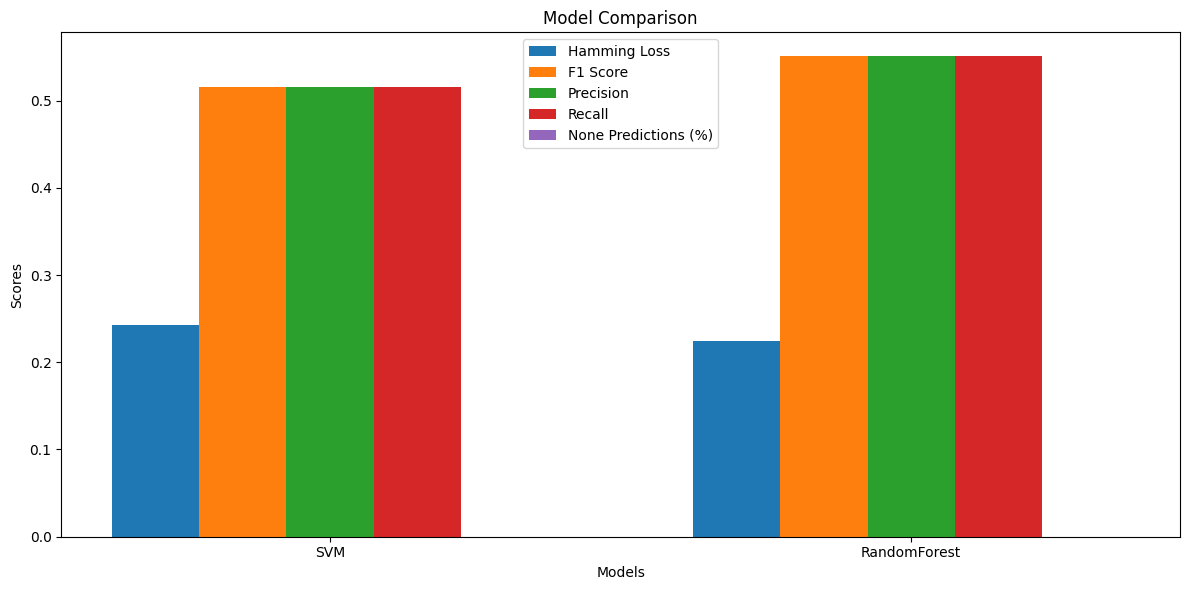


Model Comparison:

SVM:
  Hamming Loss: 0.2425
  F1 Score: 0.5151
  Precision: 0.5151
  Recall: 0.5151
  None Predictions: 0.00%
  Per-label Precision:
    healthy: 0.5778
    multiple_diseases: 0.0000
    rust: 0.4746
    scab: 0.5096
  Per-label Recall:
    healthy: 0.5200
    multiple_diseases: 0.0000
    rust: 0.4667
    scab: 0.6299

RandomForest:
  Hamming Loss: 0.2247
  F1 Score: 0.5507
  Precision: 0.5507
  Recall: 0.5507
  None Predictions: 0.00%
  Per-label Precision:
    healthy: 0.6618
    multiple_diseases: 0.0000
    rust: 0.5000
    scab: 0.5517
  Per-label Recall:
    healthy: 0.4500
    multiple_diseases: 0.0000
    rust: 0.6333
    scab: 0.6299

Plotting confusion matrices for both models...


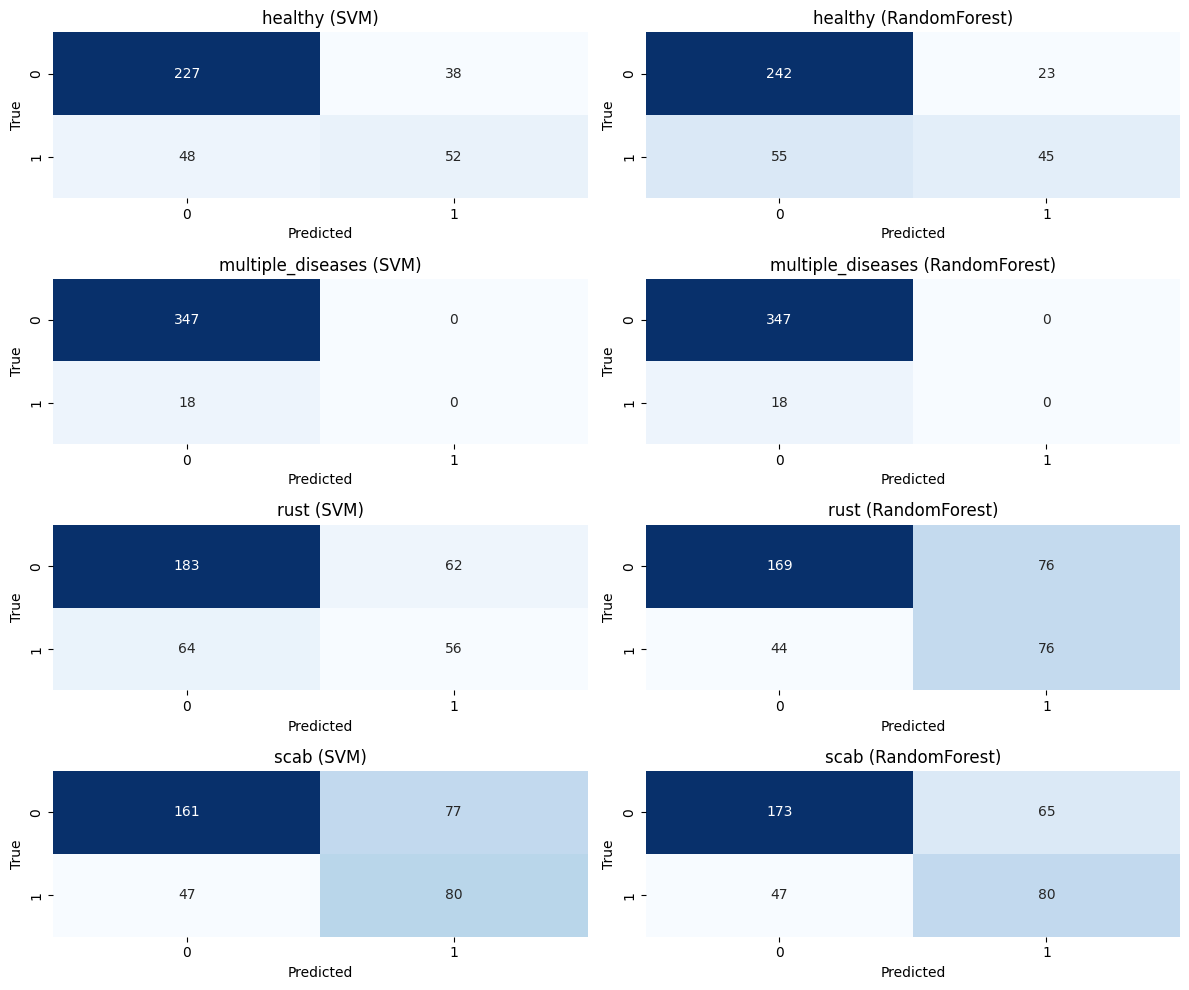


Visualizing sample predictions for SVM...


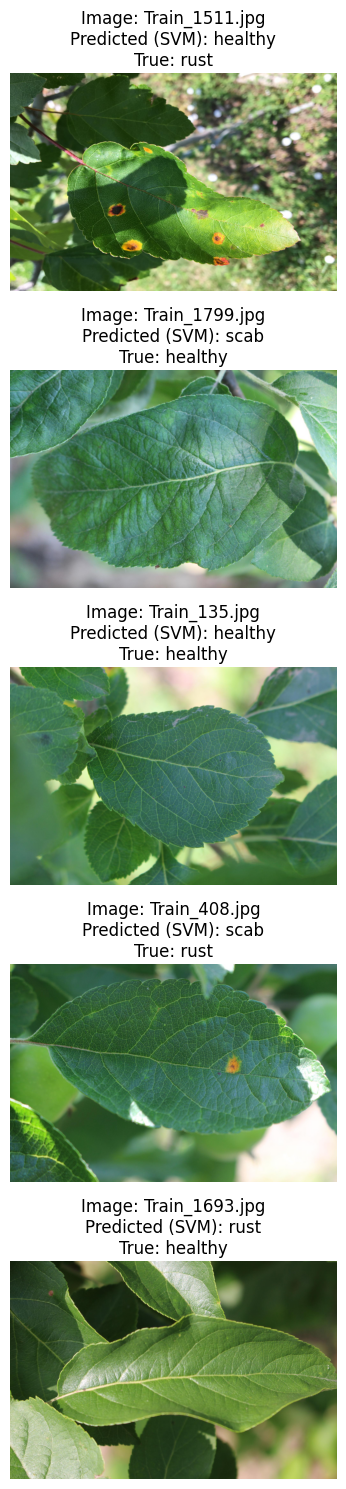

Plotting feature importance for SVM...

Visualizing sample predictions for RandomForest...


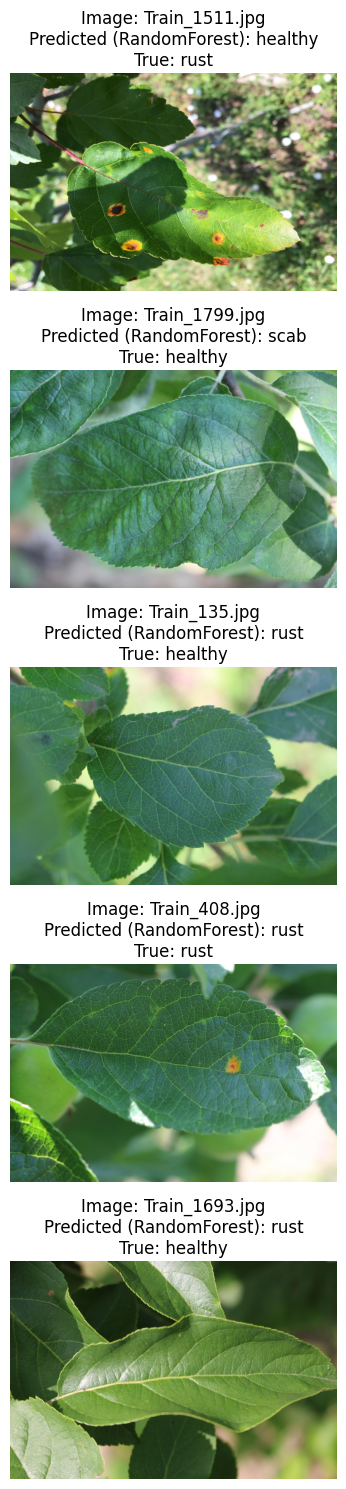

Plotting feature importance for RandomForest...


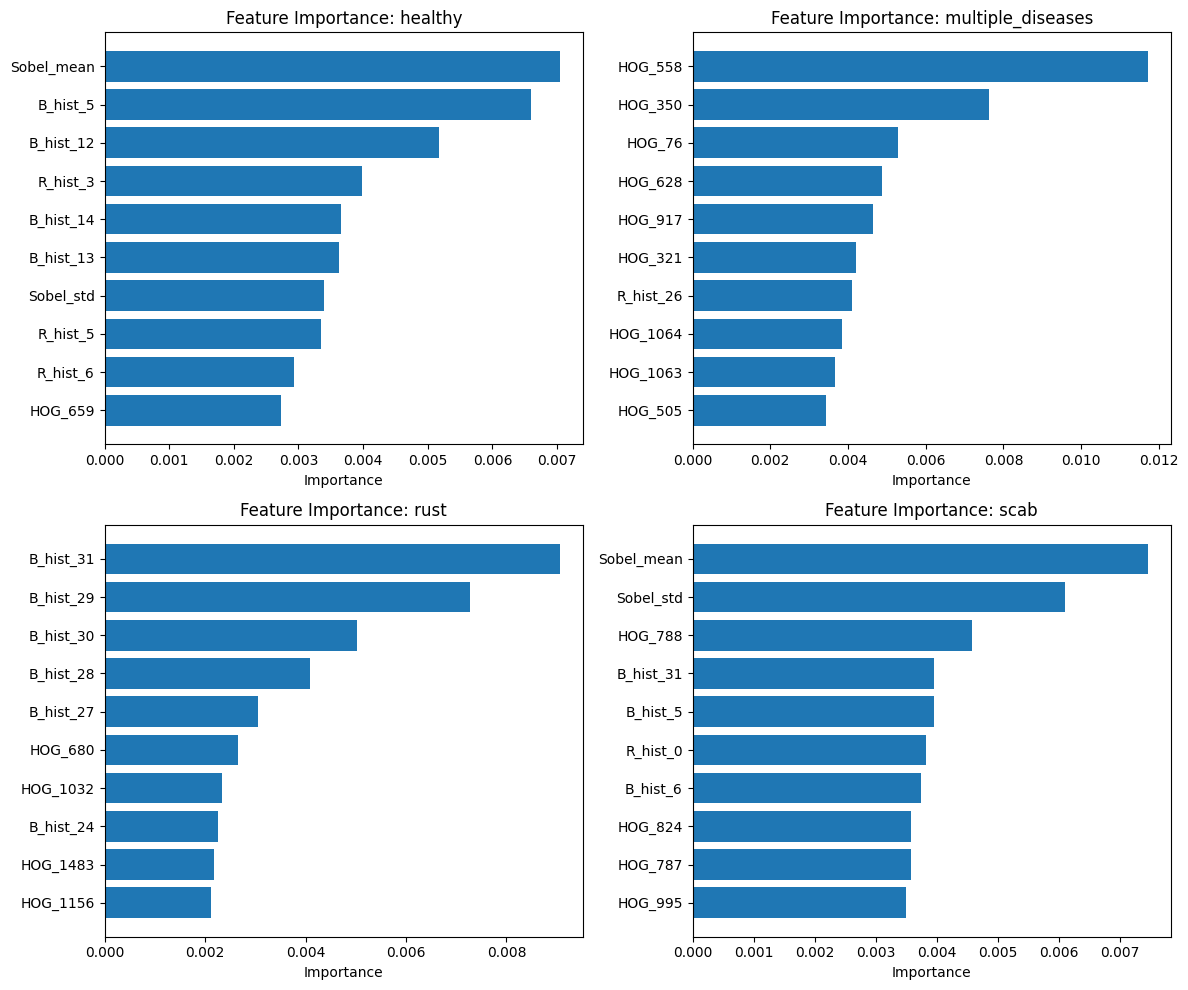


Loading and extracting features for test set...
Loaded 1821 valid samples
Predicting on test set...

Visualizing sample test predictions for SVM...


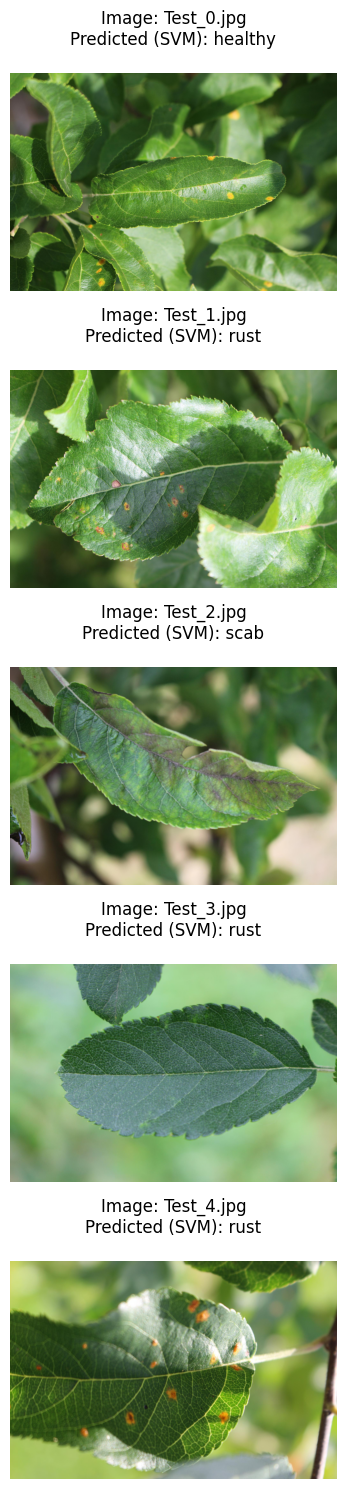


Visualizing sample test predictions for RandomForest...


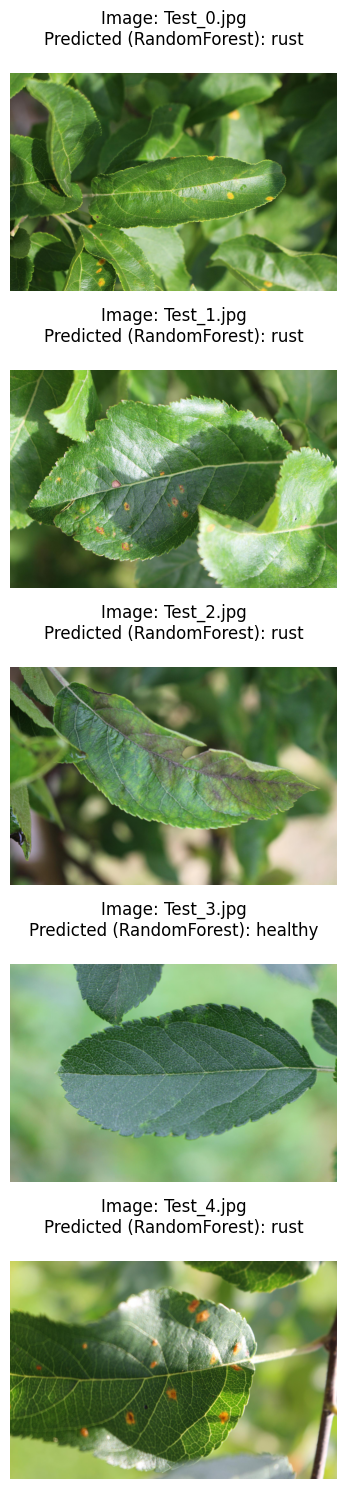

In [28]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import hamming_loss, f1_score, confusion_matrix, precision_score, recall_score
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage import filters
import multiprocessing as mp
from joblib import Parallel, delayed
import seaborn as sns

# Function to extract handcrafted features from an image
def extract_features(image_path, resize_shape=(128, 128)):
    try:
        # Read and resize image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Failed to load image: {image_path}")
            return None
        img = cv2.resize(img, resize_shape)
        
        # 1. HOG features
        gray_img = rgb2gray(img)
        hog_features, _ = hog(gray_img, orientations=8, pixels_per_cell=(16, 16),
                            cells_per_block=(2, 2), visualize=True, feature_vector=True)
        
        # 2. Color histogram (RGB channels)
        hist_r = cv2.calcHist([img], [0], None, [32], [0, 256]).flatten()
        hist_g = cv2.calcHist([img], [1], None, [32], [0, 256]).flatten()
        hist_b = cv2.calcHist([img], [2], None, [32], [0, 256]).flatten()
        color_hist = np.concatenate([hist_r, hist_g, hist_b])
        
        # 3. Texture features (using Sobel edges)
        sobel_x = filters.sobel_h(gray_img)
        sobel_y = filters.sobel_v(gray_img)
        sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
        texture_features = np.array([sobel_magnitude.mean(), sobel_magnitude.std()])
        
        # Combine all features
        features = np.concatenate([hog_features, color_hist, texture_features])
        return features
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

# Function to process a single image with error handling
def process_image(img_path, img_dir, resize_shape):
    full_path = os.path.join(img_dir, img_path)
    features = extract_features(full_path, resize_shape)
    return features

# Load and preprocess data
def load_data(csv_path, img_dir, resize_shape=(128, 128), is_train=True):
    # Validate paths
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV file not found at: {csv_path}")
    if not os.path.exists(img_dir):
        raise FileNotFoundError(f"Images directory not found at: {img_dir}")
    
    df = pd.read_csv(csv_path)
    image_paths = df['image_id'].values + '.jpg'  # Add .jpg extension
    
    if is_train:
        labels = df[['healthy', 'multiple_diseases', 'rust', 'scab']].values
        # Print class distribution
        print("\nClass distribution in training set:")
        for i, label in enumerate(['healthy', 'multiple_diseases', 'rust', 'scab']):
            print(f"{label}: {np.sum(labels[:, i])} positive samples ({np.mean(labels[:, i])*100:.2f}%)")
    else:
        labels = None
    
    # Verify that some images exist
    sample_image = os.path.join(img_dir, image_paths[0])
    if not os.path.exists(sample_image):
        raise FileNotFoundError(f"Sample image not found: {sample_image}")
    
    # Parallel feature extraction
    num_cores = mp.cpu_count()
    features = Parallel(n_jobs=num_cores)(
        delayed(process_image)(img_path, img_dir, resize_shape) 
        for img_path in image_paths
    )
    
    # Filter out None results and corresponding labels
    valid_indices = [i for i, f in enumerate(features) if f is not None]
    if len(valid_indices) == 0:
        raise ValueError("No valid features extracted from images.")
    features = [features[i] for i in valid_indices]
    image_paths = [image_paths[i] for i in valid_indices]
    
    if is_train:
        labels = labels[valid_indices]
    
    print(f"Loaded {len(features)} valid samples")
    # Calculate feature length for feature_names
    feature_length = len(features[0]) if features else 0
    return np.array(features), labels, image_paths, feature_length

# Train and evaluate multi-label classifier with single-label output
def train_and_evaluate(X, y, train_paths, test_size=0.2, random_state=42):
    # Split data
    X_train, X_test, y_train, y_test, paths_train, paths_val = train_test_split(
        X, y, train_paths, test_size=test_size, random_state=random_state
    )
    
    # Check data consistency
    print(f"Training samples: {len(X_train)}, Validation samples: {len(X_test)}")
    print(f"Validation paths: {len(paths_val)}, Validation labels: {y_test.shape[0]}")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train one classifier per label (One-vs-Rest approach)
    classifiers = {
        'SVM': [SVC(kernel='rbf', probability=True) for _ in range(y.shape[1])],
        'RandomForest': [RandomForestClassifier(n_estimators=100, random_state=random_state, class_weight='balanced') 
                        for _ in range(y.shape[1])]
    }
    
    predictions = {}
    metrics = {}
    
    for model_name, clf_list in classifiers.items():
        # Train classifiers
        for clf in clf_list:
            clf.fit(X_train_scaled, y_train[:, clf_list.index(clf)])
        
        # Get probability scores for all labels
        probas = np.array([clf.predict_proba(X_test_scaled)[:, 1] for clf in clf_list]).T
        # Select the label with the highest probability
        y_pred = np.zeros_like(probas)
        max_proba_indices = np.argmax(probas, axis=1)
        for i, idx in enumerate(max_proba_indices):
            if probas[i, idx] >= 0.3:  # Only assign if max probability >= 0.3
                y_pred[i, idx] = 1
            else:  # If no probability >= 0.3, assign the highest probability label
                y_pred[i, idx] = 1
        
        predictions[model_name] = y_pred
        
        # Calculate metrics
        hamming = hamming_loss(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='samples')
        precision = precision_score(y_test, y_pred, average='samples', zero_division=0)
        recall = recall_score(y_test, y_pred, average='samples')
        none_preds = np.mean(np.sum(y_pred, axis=1) == 0) * 100
        precision_per_label = precision_score(y_test, y_pred, average=None, zero_division=0)
        recall_per_label = recall_score(y_test, y_pred, average=None)
        metrics[model_name] = {
            'hamming_loss': hamming,
            'f1_score': f1,
            'precision': precision,
            'recall': recall,
            'none_percentage': none_preds,
            'precision_per_label': precision_per_label,
            'recall_per_label': recall_per_label
        }
        
        # Print prediction distribution and multiple_diseases specifics
        print(f"\nPrediction distribution for {model_name}:")
        label_names = ['healthy', 'multiple_diseases', 'rust', 'scab']
        for i, label in enumerate(label_names):
            print(f"{label}: {np.sum(y_pred[:, i])} positive predictions ({np.mean(y_pred[:, i])*100:.2f}%)")
        
        # Check multiple_diseases predictions
        md_idx = label_names.index('multiple_diseases')
        md_true = np.sum(y_test[:, md_idx])
        md_pred = np.sum(y_pred[:, md_idx])
        print(f"\nmultiple_diseases specifics for {model_name}:")
        print(f"  True multiple_diseases samples: {md_true} ({md_true/len(y_test)*100:.2f}%)")
        print(f"  Predicted multiple_diseases samples: {md_pred} ({md_pred/len(y_test)*100:.2f}%)")
    
    return classifiers, scaler, predictions, metrics, X_test_scaled, y_test, X_test, paths_val

# Predict on test set with single-label output
def predict_test_set(classifiers, scaler, X_test):
    X_test_scaled = scaler.transform(X_test)
    predictions = {}
    
    for model_name, clf_list in classifiers.items():
        probas = np.array([clf.predict_proba(X_test_scaled)[:, 1] for clf in clf_list]).T
        y_pred = np.zeros_like(probas)
        max_proba_indices = np.argmax(probas, axis=1)
        for i, idx in enumerate(max_proba_indices):
            if probas[i, idx] >= 0.3:
                y_pred[i, idx] = 1
            else:
                y_pred[i, idx] = 1
        
        predictions[model_name] = y_pred
    
    return predictions

# Visualize sample images with predictions
def visualize_samples(img_dir, image_paths, y_true, y_pred, model_name, num_samples=5):
    label_names = ['healthy', 'multiple_diseases', 'rust', 'scab']
    num_samples = min(num_samples, len(image_paths), y_pred.shape[0])
    if num_samples == 0:
        print(f"No samples to visualize for {model_name}")
        return
    
    plt.figure(figsize=(15, 3 * num_samples))
    
    for i in range(num_samples):
        img_path = os.path.join(img_dir, image_paths[i])
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image: {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Get predicted and true labels
        pred_labels = [label_names[j] for j, val in enumerate(y_pred[i]) if val == 1]
        pred_text = f"Predicted ({model_name}): {', '.join(pred_labels) if pred_labels else 'None'}"
        if y_true is not None:
            true_labels = [label_names[j] for j, val in enumerate(y_true[i]) if val == 1]
            true_text = f"True: {', '.join(true_labels) if true_labels else 'None'}"
        else:
            true_text = ""
        
        # Plot image
        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(img)
        plt.title(f"Image: {image_paths[i]}\n{pred_text}\n{true_text}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(f'sample_predictions_{model_name}.png')
    plt.show()

# Visualize confusion matrices
def plot_confusion_matrices(y_true, predictions, model_names):
    label_names = ['healthy', 'multiple_diseases', 'rust', 'scab']
    plt.figure(figsize=(12, 10))
    
    for i, label in enumerate(label_names):
        for j, model_name in enumerate(model_names):
            y_pred = predictions[model_name]
            cm = confusion_matrix(y_true[:, i], y_pred[:, i])
            plt.subplot(len(label_names), len(model_names), i * len(model_names) + j + 1)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
            plt.title(f'{label} ({model_name})')
            plt.xlabel('Predicted')
            plt.ylabel('True')
    
    plt.tight_layout()
    plt.savefig('confusion_matrices_comparison.png')
    plt.show()

# Compare model metrics
def compare_models(metrics):
    model_names = list(metrics.keys())
    label_names = ['healthy', 'multiple_diseases', 'rust', 'scab']
    hamming_losses = [metrics[model]['hamming_loss'] for model in model_names]
    f1_scores = [metrics[model]['f1_score'] for model in model_names]
    precisions = [metrics[model]['precision'] for model in model_names]
    recalls = [metrics[model]['recall'] for model in model_names]
    none_percentages = [metrics[model]['none_percentage'] for model in model_names]
    
    # Plot overall metrics
    x = np.arange(len(model_names))
    width = 0.15
    
    plt.figure(figsize=(12, 6))
    plt.bar(x - 2*width, hamming_losses, width, label='Hamming Loss')
    plt.bar(x - width, f1_scores, width, label='F1 Score')
    plt.bar(x, precisions, width, label='Precision')
    plt.bar(x + width, recalls, width, label='Recall')
    plt.bar(x + 2*width, none_percentages, width, label='None Predictions (%)')
    
    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.title('Model Comparison')
    plt.xticks(x, model_names)
    plt.legend()
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()
    
    # Print detailed comparison
    print("\nModel Comparison:")
    for model in model_names:
        print(f"\n{model}:")
        print(f"  Hamming Loss: {metrics[model]['hamming_loss']:.4f}")
        print(f"  F1 Score: {metrics[model]['f1_score']:.4f}")
        print(f"  Precision: {metrics[model]['precision']:.4f}")
        print(f"  Recall: {metrics[model]['recall']:.4f}")
        print(f"  None Predictions: {metrics[model]['none_percentage']:.2f}%")
        print("  Per-label Precision:")
        for i, label in enumerate(label_names):
            print(f"    {label}: {metrics[model]['precision_per_label'][i]:.4f}")
        print("  Per-label Recall:")
        for i, label in enumerate(label_names):
            print(f"    {label}: {metrics[model]['recall_per_label'][i]:.4f}")

# Visualize Random Forest feature importance
def plot_feature_importance(classifiers, model_name, feature_names):
    if model_name != 'RandomForest':
        return
    label_names = ['healthy', 'multiple_diseases', 'rust', 'scab']
    plt.figure(figsize=(12, 10))
    
    for i, clf in enumerate(classifiers[model_name]):
        importances = clf.feature_importances_
        num_features = min(10, len(importances))  # Ensure we don't exceed available features
        indices = np.argsort(importances)[-num_features:]  # Top features
        plt.subplot(2, 2, i + 1)
        plt.barh(range(num_features), importances[indices], align='center')
        plt.yticks(range(num_features), [feature_names[j] for j in indices if j < len(feature_names)])
        plt.title(f'Feature Importance: {label_names[i]}')
        plt.xlabel('Importance')
    
    plt.tight_layout()
    plt.savefig(f'feature_importance_{model_name}.png')
    plt.show()

# Main execution
def main():
    # Kaggle dataset paths
    data_dir = '/kaggle/input/plant-pathology-2020-fgvc7'
    csv_path = os.path.join(data_dir, 'train.csv')
    test_csv_path = os.path.join(data_dir, 'test.csv')
    img_dir = os.path.join(data_dir, 'images')
    
    # Validate paths
    print(f"Checking CSV path: {csv_path}")
    print(f"Checking test CSV path: {test_csv_path}")
    print(f"Checking images directory: {img_dir}")
    
    try:
        # Load training data
        print("Loading and extracting features for training set...")
        X, y, train_paths, feature_length = load_data(csv_path, img_dir, is_train=True)
        
        # Dynamically create feature names based on actual feature length
        hog_length = feature_length - (32 + 32 + 32 + 2)  # Subtract histograms and Sobel features
        feature_names = [f'HOG_{i}' for i in range(hog_length)] + \
                        [f'R_hist_{i}' for i in range(32)] + \
                        [f'G_hist_{i}' for i in range(32)] + \
                        [f'B_hist_{i}' for i in range(32)] + \
                        ['Sobel_mean', 'Sobel_std']
        print(f"Total features: {feature_length}, HOG features: {hog_length}")
        
        # Train and evaluate models
        print("Training models...")
        classifiers, scaler, predictions, metrics, X_test_scaled, y_test, X_test, paths_val = train_and_evaluate(X, y, train_paths)
        
        # Compare models
        compare_models(metrics)
        
        # Plot confusion matrices for both models
        print("\nPlotting confusion matrices for both models...")
        plot_confusion_matrices(y_test, predictions, ['SVM', 'RandomForest'])
        
        # Visualize sample validation images and feature importance
        for model_name in predictions:
            print(f"\nVisualizing sample predictions for {model_name}...")
            visualize_samples(img_dir, paths_val, y_test, predictions[model_name], model_name)
            
            print(f"Plotting feature importance for {model_name}...")
            plot_feature_importance(classifiers, model_name, feature_names)
        
        # Load and predict on test set
        print("\nLoading and extracting features for test set...")
        X_test, _, test_image_paths, _ = load_data(test_csv_path, img_dir, is_train=False)
        
        print("Predicting on test set...")
        test_predictions = predict_test_set(classifiers, scaler, X_test)
        
        # Visualize sample test images (predictions only, no true labels)
        for model_name in test_predictions:
            print(f"\nVisualizing sample test predictions for {model_name}...")
            visualize_samples(img_dir, test_image_paths, None, test_predictions[model_name], model_name)
    
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please ensure the dataset files are available in /kaggle/input/plant-pathology-2020-fgvc7/")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        raise

if __name__ == '__main__':
    main()